# Demo: Nonloc heatflux

This notebook provide a demo case on the application of the heat conduction solver.
<br>

## Geometry & Computational Grid
In this case, we will consider a 1d plasma with temperature, electron density, ionization rate and Knudsen number profiles, provided by kinetic simulation with length $L  = 0.19$ cm.  We will use $N=400$ nodes for this profile. As you can see, the grid spacing, $dx$ will be $L/(N-1)=476$ $\mu \mathrm{m}$.

First, import parameter module in order to get a Pandas series containing all the parameters.
Last two rows contain a NN training part. The `io.capture_output` function is used to avoid the overfilling of output (to many messages are displayed and VS Code can't manage that)

In case coefficients $\alpha$ and $\beta$ are defined without using the NN, use `model = None`

In [1]:
import importlib
from IPython.utils import io
import NN_training
importlib.reload(NN_training)
%matplotlib widget

In [2]:
with io.capture_output() as captured:
    model=NN_training.train_model(100) #argument is the number of epochs
    #model=None 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type    | Params
-------------------------------------
0 | fcIn     | Linear  | 2.8 K 
1 | fcOut    | Linear  | 62    
2 | mse_loss | MSELoss | 0     
-------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.011     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.



All parameters of the problem, such as number of used profiles points, boundary conditions, definition of parameters $\alpha$ and $\beta$, number of timesteps and its magnitude $dt$ are contained and may be modified in `parameter.py` file.

`importlib` module and `reload` function in particullar are used to update modules if modified

`heatConduction.py` package contains necessary components to solve the PDEs.
It also creates a `matplotlib` figure, which will display heatflux calculated using neural network, (if) trained in first cell.

Next cell initiates solution of the problem. The result temperature profiles, last cache and coefficients are contained in these four variables accordingly

### Non-local transport using NN

In [3]:
import importlib
import parameter as param
import heatConduction as hc
import utility
importlib.reload(hc)
importlib.reload(param)   #In order to apply changes in the module 
importlib.reload(utility)   #In order to apply changes in the module 
para = param.main(model)


results, cache, alphas, betas, heatflux = hc.solve(para)

 Heat Conduction Solver
 [Step] [Time] [Iter] [Residue] [Newton outcome] [Max beta] [Max alpha] [Minimal T] [Maximal T] [meanEnergy]
[  1 ] [7.66E-13 ] [10 ] [1.37E-08 ] [4.57E+00 ] [2.57E+00 ] [1.01E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312980475059E+12 ]
[  2 ] [1.53E-12 ] [ 7 ] [3.36E-09 ] [8.53E+01 ] [2.83E+00 ] [3.04E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312860087212E+12 ]
[  3 ] [2.30E-12 ] [ 4 ] [2.87E-09 ] [2.67E+00 ] [2.70E+00 ] [1.14E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312953668438E+12 ]
[Cost] CPU time spent 12.106 s


### Newton-Krylov
TODO: Fix the problem with zero vector

There's problem with `scipy.optimize` residing in that my residiual vector F (difference in energy between `i`-th and `i+1`-th time steps) is fairly huge. 

As a result of it, the calculated inverse jacobian is of such small value, that `scipy.optimize` takes it as ZERO VECTOR and raises `ValueError`.
I had to either normalize ALL the data, or simply divide F by its norm. We're looking for F=0 after all.

I've done the latter. 

In [8]:
#LOCAL TRANSPORT
import heatConduction_NK
import physics
import parameter as param
importlib.reload(physics)
importlib.reload(heatConduction_NK)
importlib.reload(param) 
NK_para = param.main(None)
NK_results, NK_cache, NK_alphas, NK_betas, NK_heatflux = heatConduction_NK.solve(NK_para)

 Heat Conduction Solver
Use SH ? False
 [Step] [Time] [Iter] [Residue] [Newton outcome] [Max beta] [Max alpha] [Minimal T] [Maximal T] [meanEnergy]
[  1 ] [7.66E-13 ] [20 ] [1.96E-19 ] [1.59E-32 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630317176910293E+12 ]
[  2 ] [1.54E-12 ] [20 ] [5.77E-19 ] [3.51E-31 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.54E+03 ] [3.2630314998800039E+12 ]
[  3 ] [2.32E-12 ] [20 ] [9.62E-20 ] [7.31E-32 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.53E+03 ] [3.2630315383668564E+12 ]
[  4 ] [3.11E-12 ] [20 ] [7.38E-19 ] [6.28E-31 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.52E+03 ] [3.2630317834576211E+12 ]
[  5 ] [3.91E-12 ] [20 ] [4.85E-19 ] [4.49E-31 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.51E+03 ] [3.2630319613433950E+12 ]
[  6 ] [4.72E-12 ] [20 ] [9.63E-19 ] [9.54E-31 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.49E+03 ] [3.2630321928969126E+12 ]
[  7 ] [5.54E-12 ] [20 ] [4.50E-19 ] [4.75E-31 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.48E+03 ] [3.26303231192636

### SH limiter (flim=0.17)
Again I implemented Newton Krylov, as I'm to lazy to rewrite exact jacobian. Took me a full day anyway.

In [7]:
importlib.reload(physics)
importlib.reload(heatConduction_NK)
importlib.reload(param) 
NKSH_para = param.main(None)
NKSH_results, NKSH_cache, NKSH_alphas, NKSH_betas, NKSH_heatflux = heatConduction_NK.solve(NKSH_para, SH=True)

 Heat Conduction Solver
Use SH ? True
 [Step] [Time] [Iter] [Residue] [Newton outcome] [Max beta] [Max alpha] [Minimal T] [Maximal T] [meanEnergy]
[  1 ] [7.66E-13 ] [20 ] [3.57E-17 ] [3.01E-18 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312534407139E+12 ]
[  2 ] [1.53E-12 ] [20 ] [3.57E-17 ] [3.01E-18 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312534407075E+12 ]
[  3 ] [2.30E-12 ] [20 ] [3.57E-17 ] [3.01E-18 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312534407007E+12 ]
[  4 ] [3.07E-12 ] [20 ] [3.57E-17 ] [3.01E-18 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312534406943E+12 ]
[  5 ] [3.83E-12 ] [20 ] [3.57E-17 ] [3.01E-18 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312534406875E+12 ]
[  6 ] [4.60E-12 ] [20 ] [3.57E-17 ] [3.01E-18 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312534406812E+12 ]
[  7 ] [5.36E-12 ] [20 ] [3.57E-17 ] [3.01E-18 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.263031253440674

### Local transport ($\alpha = 1$ , $\beta=5/2$)

In [7]:
importlib.reload(hc)
importlib.reload(param)   #In order to apply changes in the module 
importlib.reload(utility)   #In order to apply changes in the module 

loc_para = param.main(None)

loc_results, loc_cache, loc_alphas, loc_betas, loc_heatflux = hc.solve(loc_para)

 Heat Conduction Solver
 [Step] [Time] [Iter] [Residue] [Newton outcome] [Max beta] [Max alpha] [Minimal T] [Maximal T] [meanEnergy]
[  1 ] [7.66E-13 ] [10 ] [1.36E-08 ] [5.71E-06 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312978999473E+12 ]
[  2 ] [1.53E-12 ] [ 7 ] [3.52E-09 ] [5.46E-06 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630312864695850E+12 ]
[  3 ] [2.30E-12 ] [ 5 ] [4.29E-09 ] [8.39E-06 ] [2.50E+00 ] [1.00E+00 ] [2.74E+02 ] [2.55E+03 ] [3.2630313004696099E+12 ]
[Cost] CPU time spent 0.678 s


In [ ]:
(3.2630312978999473E+12  -3.2630313004696099E+12)

-2569.66259765625

The `results` is a numpy array consist of evolution of each time step over the domain. The `cache` file is a Python dictionary consists of some variables used by debugging. <br>
In order to view the results, import the postprocessing package and preprocess the results. <br>
The preprocess transform the numpy array into a Pandas DataFrame, with index as grid locations and columns as timings.

## Visualization of $\alpha$ and $\beta$

In [ ]:
import pandas as pd
import postprocessing as pp
importlib.reload(pp)
import matplotlib.pyplot as plt

# Enables better (IMO) styles for plots in cost of perfomance
if True:
    import scienceplots
    plt.style.use('science')
#

T = pd.DataFrame(results)
T_loc = pd.DataFrame(loc_results)
T_NK = pd.DataFrame(test_results)
alpha3d=pd.DataFrame(alphas, columns=T.columns,index=T.index)
beta3d=pd.DataFrame(betas, columns=T.columns,index=T.index)
heatflux3d=pd.DataFrame(heatflux, columns=T.columns,index=T.index)

endframe=-1  #last timestep that will be visualized. I use it in case hc.solve calculation is corrupted in order to all e

## Visualization of temperature profiles
The first plot is the evolution field in both time and space. We can view the results in a 3D contour plot by just passing the processed T to the function evolutionField(). <br>
It can be seen that the temperature over the var is increasing as time elapses.

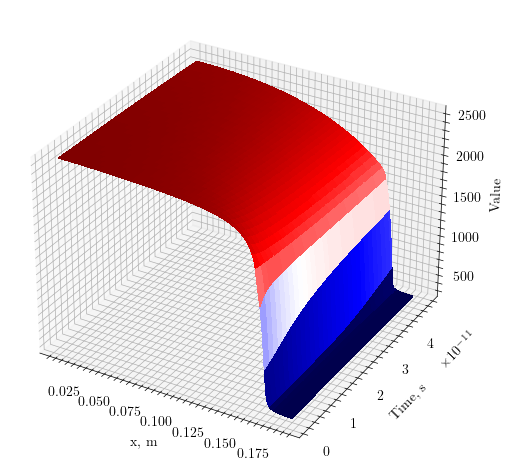

In [ ]:
###LOCAL###
pp.evolutionField(T_loc[T_loc.columns[:endframe]])

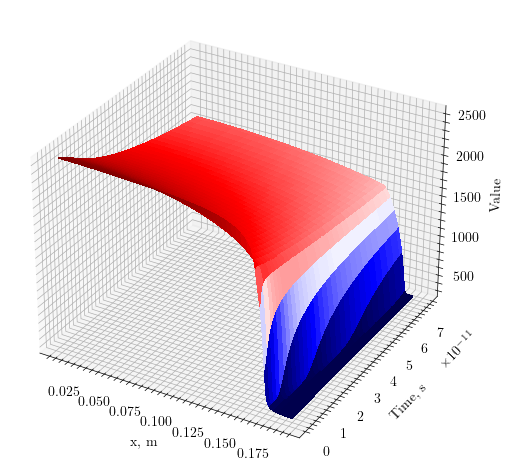

In [ ]:
pp.evolutionField(T_NK[T_NK.columns[:endframe]])

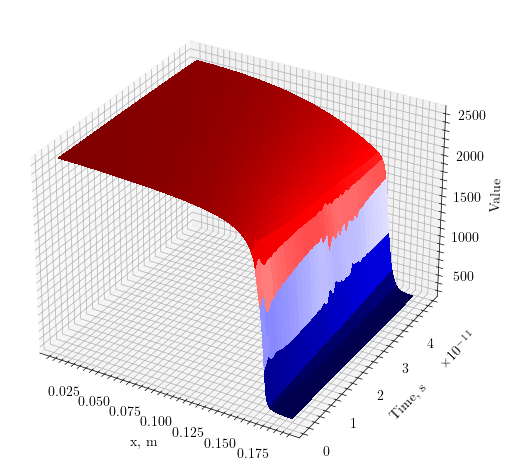

In [ ]:
pp.evolutionField(T[T.columns[:endframe]])

### Comparing the last T profile

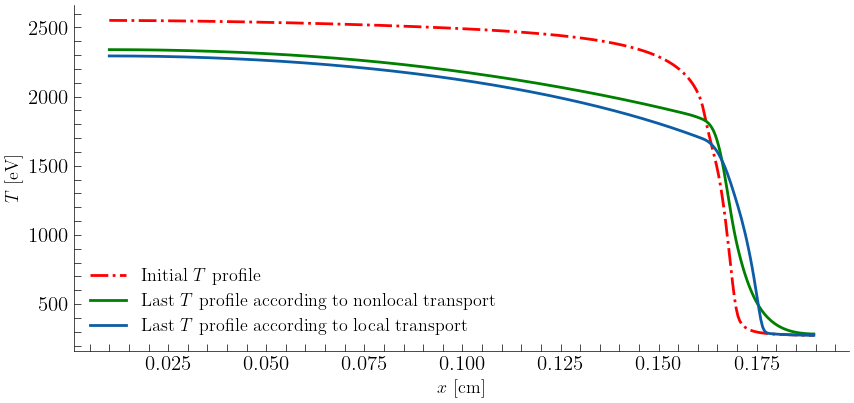

In [ ]:
import matplotlib.pyplot as plt
fg_compare, axs_compare = plt.subplots(figsize=(10,4.5))
axs_compare.plot(para['x'], T_loc[T_loc.columns[0]], label=r'Initial $T$ profile', lw=2, ls='-.', color='r')
axs_compare.plot(para['x'], T[T.columns[-1]], label=r'Last $T$ profile according to nonlocal transport', lw=2, ls='-',color='g')
axs_compare.plot(para['x'], T_loc[T_loc.columns[-1]], label=r'Last $T$ profile according to local transport', lw=2, ls='-')
axs_compare.spines['top'].set_visible(False)
axs_compare.spines['right'].set_visible(False)
axs_compare.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True, labelsize=15, size=5)
axs_compare.tick_params(axis='y',which='both',left=True,right=False, labelsize=15, size=5)
axs_compare.set_xlabel(r'$x$ [cm]', fontsize=13)
axs_compare.set_ylabel(r'$T$ [eV]', fontsize=13)
axs_compare.legend(loc='best', fontsize=13)


### Calculate profiles of $\nabla{T}$ and Kn

In [ ]:
import numpy as np
alpha_profs=alpha3d[alpha3d.columns[:endframe]].copy()
gradTprofile = pd.DataFrame()
preKnprofile = pd.DataFrame()
for step, timestep in enumerate(T.columns[:endframe]):
    gradTprofile[T.columns[step]]=np.gradient(np.reshape(T[alpha_profs.columns[step]], (400)),para['x'])
    preKnprofile[T.columns[step]]=np.gradient(np.reshape(T[alpha_profs.columns[step]], (400)),para['x'])/np.reshape(T[alpha_profs.columns[step]], (400))

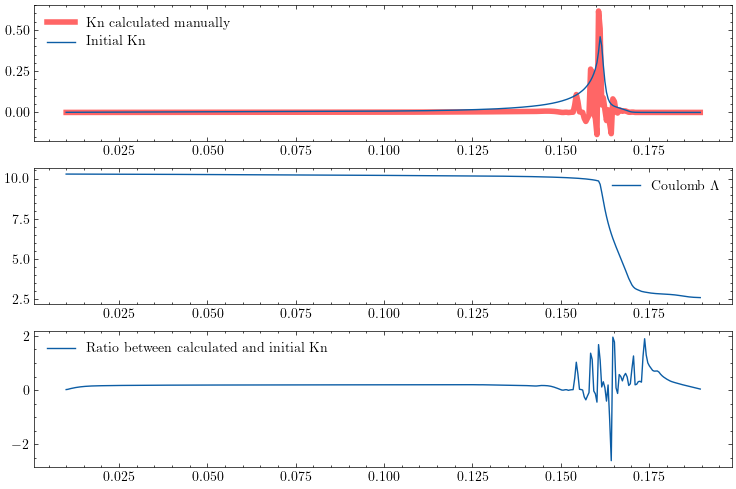

In [ ]:
import matplotlib.pyplot as plt
Knprofile=pd.DataFrame(cache['Kn_prof'], columns=cache['times'],index=para['x'])
CoulombLog=23-np.log(np.sqrt(cache['ne'])*para['InitZbarProfile']/para['InitTeProfile']**1.5)
#CoulombLog = np.ones(400)
knfig, knax = plt.subplots(3,1, figsize=(9,6))
knax[0].plot(para['x'], Knprofile[T.columns[1]], alpha=0.6, lw=4, color='red', label='Kn calculated manually')
knax[0].plot(para['x'], para['InitKnProfile'], label='Initial Kn')
knax[1].plot(para['x'], CoulombLog, label=r'Coulomb $\Lambda$')
knax[2].plot(para['x'], Knprofile[T.columns[1]] / para['InitKnProfile'], label='Ratio between calculated and initial Kn')
knax[0].legend(loc='best')
knax[1].legend(loc='best')
knax[2].legend(loc='best')

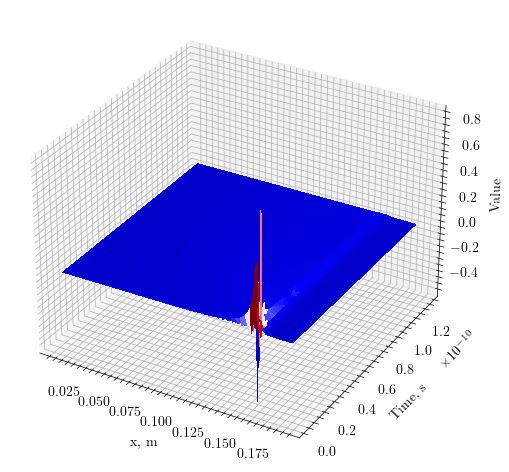

In [ ]:
pp.evolutionField(Knprofile[T.columns[:endframe]])

### $\nabla{T}$ evolution

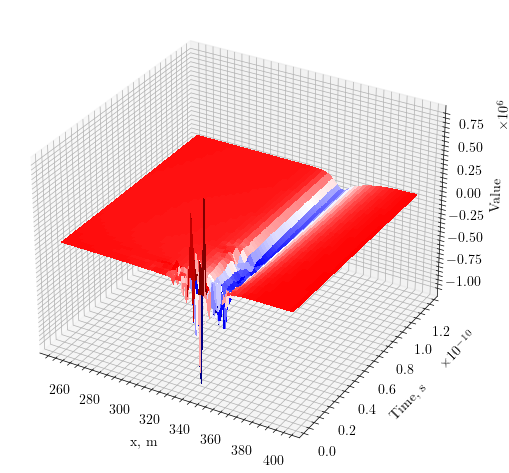

In [ ]:
pp.evolutionField(gradTprofile[T.columns[:endframe]].iloc[250:])

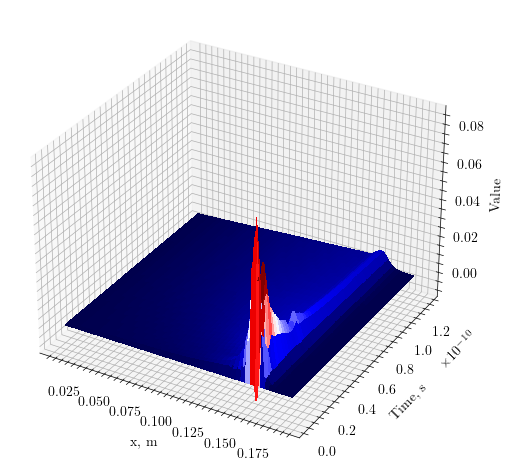

In [ ]:
Kn_nonloc_profile=pd.DataFrame(cache['Kn_nonloc_prof'], columns=cache['times'],index=para['x'])
pp.evolutionField(Kn_nonloc_profile[T.columns[:endframe]])

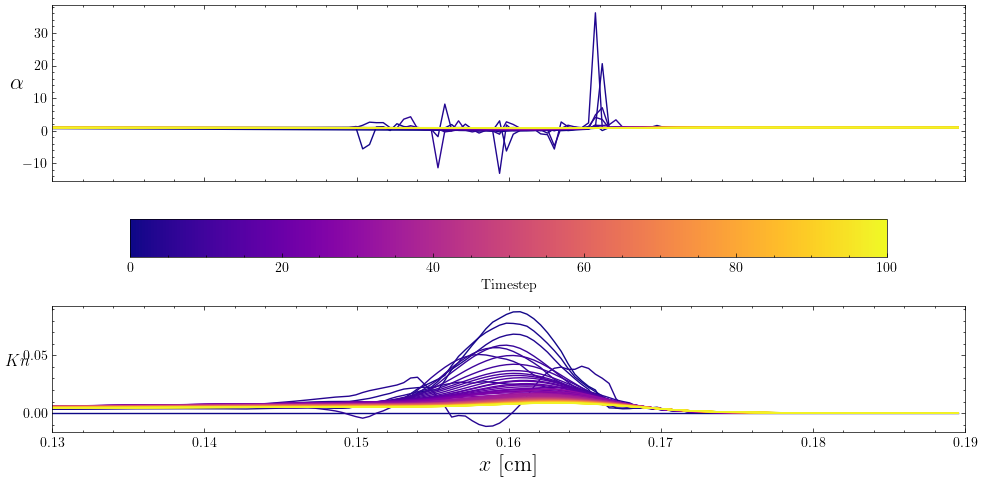

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pl
#timestep=26

f, ax = plt.subplots(2,1, sharex=True, figsize=(10,5),gridspec_kw={'height_ratios': [2, 1]})
step=1
endtime = endframe
leng=len(alpha3d.columns[:endtime:step])
colors = pl.cm.plasma(np.linspace(0,1,leng+1))

for i, _ in enumerate(alpha3d.columns[:endtime:step]):
    ax[0].plot( alpha3d.index, alpha3d[alpha3d.columns[i*step]], color = colors[i])
    ax[1].plot( alpha3d.index, Kn_nonloc_profile[alpha3d.columns[i*step]],color = colors[i])
    #ax[2].plot( alpha3d.index, heatflux3d[alpha3d.columns[i*step]], color = ((i*step)/120, 0, (120-i*step)/120,(120-0.8*i*step)/120))
ax[0].set_ylabel(r'$\alpha$',rotation=0, fontsize=16)
ax[0].set_xlim([0.13,0.19])
ax[1].set_ylabel(r'$Kn$',rotation=0,  fontsize=12)
ax[1].set_xlabel(r'$x$ [cm]',rotation=0,  fontsize=16)
colormap= plt.cm.get_cmap('plasma')
sm=plt.cm.ScalarMappable(cmap=colormap)
sm.set_clim(vmin=0, vmax=leng)

f.colorbar(sm,ax=ax[0],label="Timestep", orientation="horizontal")
f.tight_layout(pad=1.0)

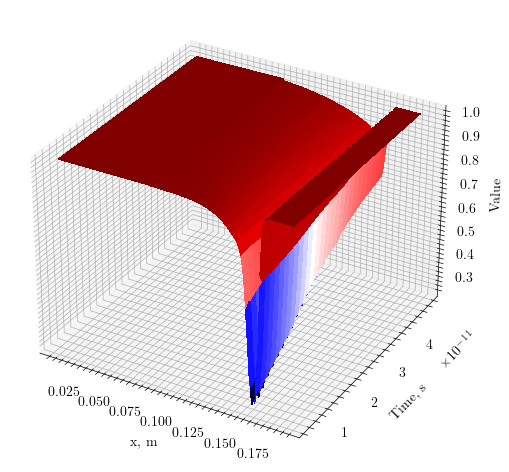

In [ ]:
pp.evolutionField(alpha3d[T.columns[5:endframe]])

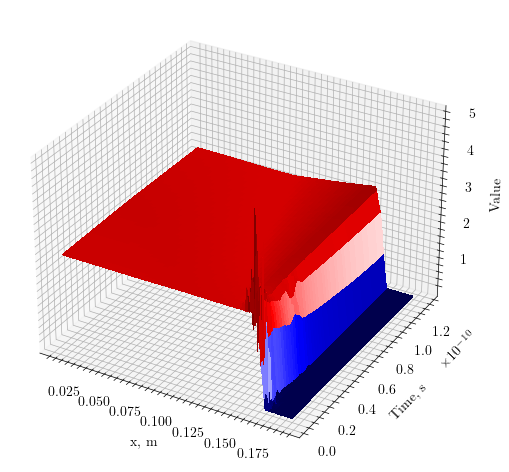

In [ ]:
pp.evolutionField(beta3d[T.columns[:endframe]])

### Heatflux according to NN

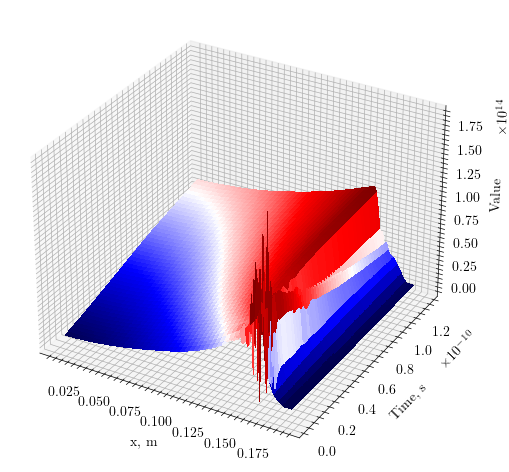

In [ ]:
pp.evolutionField(heatflux3d[T.columns[:endframe]])

### Calculated Heatflux

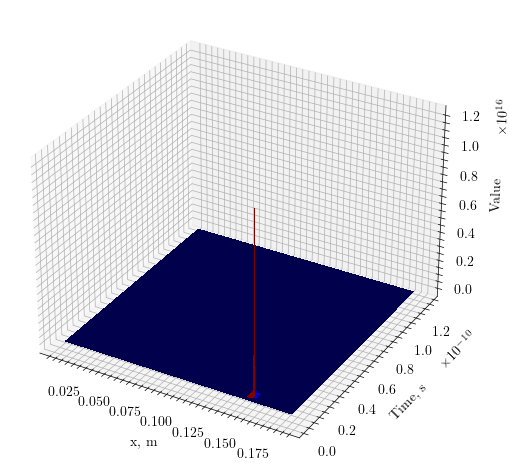

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
init_profile=pd.read_csv('./Data/init_profile.csv', index_col=(0)).iloc[::100,:]
data_scaling = pd.read_csv(f'./Data/data_scaling.csv', header=0, index_col=0)
nescaled  = (init_profile['ne']-data_scaling['n'].loc['mean'])/data_scaling['n'].loc['std']
Zscaled = (init_profile['Zbar']-data_scaling['Z'].loc['mean'])/data_scaling['Z'].loc['std']
Knscaled  = (init_profile['Kn']-data_scaling['Kn'].loc['mean'])/data_scaling['Kn'].loc['std']
Z=np.array(init_profile['Zbar'])

calheatdflux = pd.DataFrame()
for col in T.columns[:endframe]:
    calheatdflux[col]=- alpha3d[col]/Z *(Z+0.24)/(Z+4.2) * T[col]**(beta3d[col])*np.gradient(T[col])
pp.evolutionField(calheatdflux)

### Ratio between nonlocal and local heatflux qqRatio=$\frac{Q_{NN}}{Q_{loc}}$

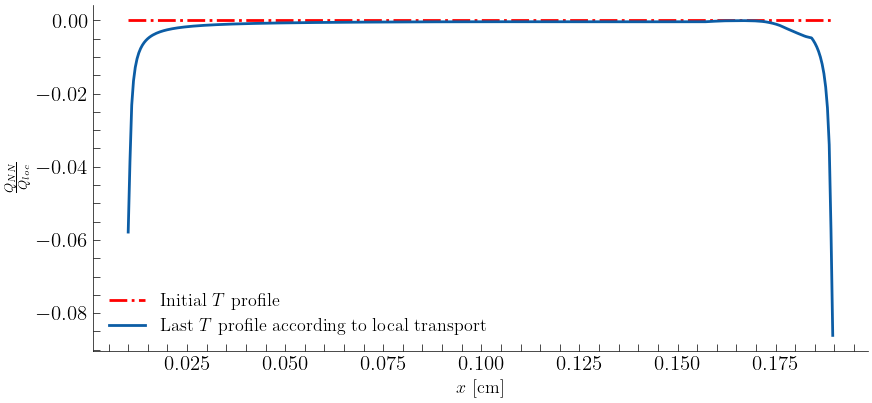

In [ ]:
qqRatio=pd.DataFrame(cache['qqratio_prof'], columns=cache['times'],index=para['x'])

qqfig, qqax = plt.subplots(figsize=(10,4.5))
qqax.plot(para['x'], qqRatio[qqRatio.columns[0]], label=r'Initial $T$ profile', lw=2, ls='-.', color='r')
qqax.plot(para['x'], qqRatio[qqRatio.columns[-1]], label=r'Last $T$ profile according to local transport', lw=2, ls='-')
qqax.spines['top'].set_visible(False)
qqax.spines['right'].set_visible(False)
qqax.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True, labelsize=15, size=5)
qqax.tick_params(axis='y',which='both',left=True,right=False, labelsize=15, size=5)
qqax.set_xlabel(r'$x$ [cm]', fontsize=13)
qqax.set_ylabel(r'$\frac{Q_{NN}}{Q_{loc}}$', fontsize=13)
qqax.legend(loc='best', fontsize=13)

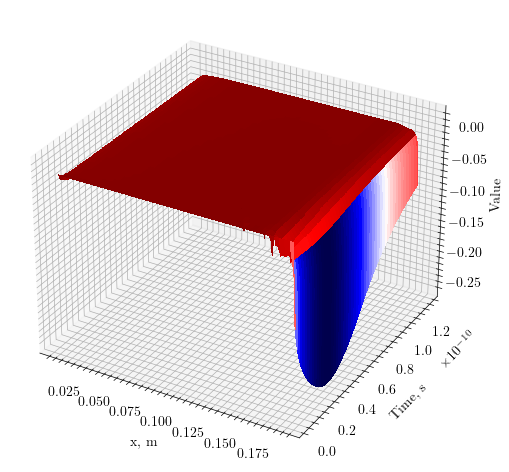

In [ ]:
pp.evolutionField(qqRatio[T.columns[:endframe]])

### Energy distribution

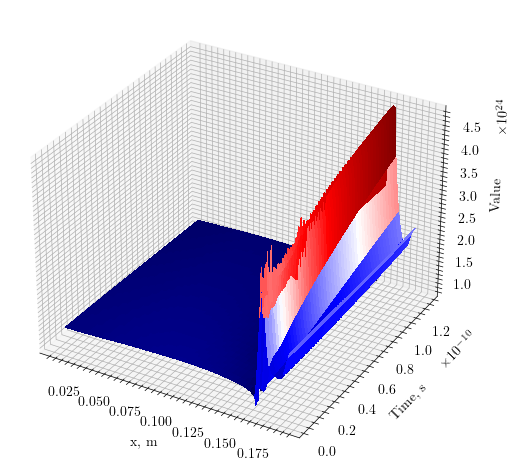

In [ ]:
E=(T.T*init_profile['ne'].values).T
pp.evolutionField(E[E.columns[:endframe]])

This notebook and the whole structure of the modules solving the time evolution of temperature distribution are based on github heatConduction repository published by https://github.com/rickfu415